**Şuan taslak aşamasında, farklı notebooklardanbirçok kodun copy-paste hali var, iş yerinden bu notelarıma erşiebilmek için eklemiş durumdayım. Bakmanızı tavsiye etmem**

In [1]:
%%javascript
var rto = 120;
console.log('NB: Increase require timeout to ' + rto + ' seconds');
window.requirejs.config({waitSeconds: rto});

<IPython.core.display.Javascript object>

# Kurulum

ben nasıl krudysam öyle, haddop home v.s unutma, restart etmeyi de unutma, hemen olmaz

findspark olayını da yazalım

# Giriş

In [1]:
import findspark
findspark.init()

In [2]:
import os
import sys
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [3]:
from pyspark.sql import SparkSession
spark=SparkSession.Builder().config("spark.sql.warehouse.dir", "E:\OneDrive\Dökümanlar\GitHub\PythonRocks").getOrCreate()
#config kısmı, sql kullanırken gerekti

In [66]:
import pyspark.pandas as psd
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import *

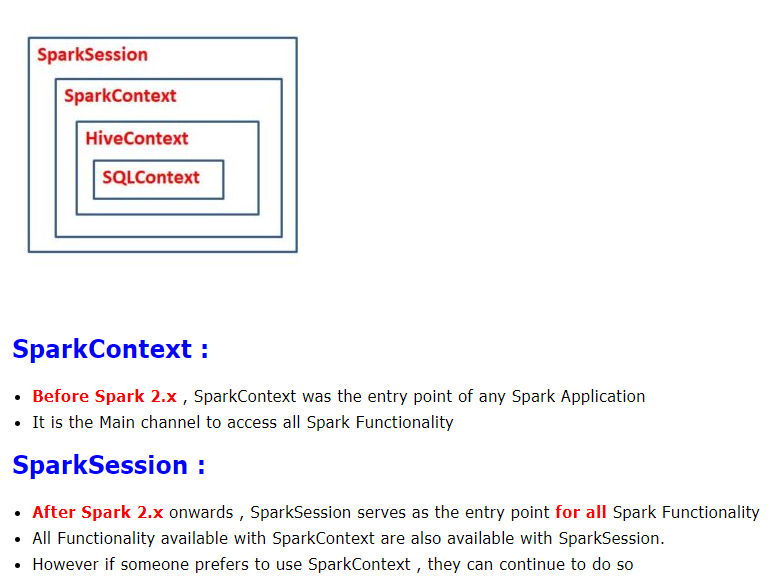

- https://gankrin.org/sparksession-vs-sparkcontext-vs-sqlcontext-vs-hivecontext/
- https://towardsdatascience.com/sparksession-vs-sparkcontext-vs-sqlcontext-vs-hivecontext-741d50c9486a

In [ ]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc

SparkSession ayrattıysan, ve bir şekilde SparkContext'e ihtiyaç olursa, mesela bi listeyi rdd yapmak için sc'nin parallelize'ına ihtiyaç lazım olur.


```
from pyspark.sql import SparkSession
spark = SparkSession.Builder().getOrCreate()
sc=spark.sparkContext
```



In [ ]:
sc=spark.sparkContext

# RDD

In [ ]:
numbers=[1,2,3,4,5,6,7,8]
kareler=[]

In [ ]:
rdd=sc.parallelize(numbers) #sıradan bir python listesi RDDye dönüştü

In [ ]:
for i in numbers:
  kareler.append(i**2)

Sparkta index kullanımı olmadığı için sequential işler de yapılamaz, yani for döngüsü de kullanılamaz. ASlında global listenin indekisini kullanamayız.

Bunun yerine iki tür işlem var. Transformation(yine bir RDD üretir) ve Action(non-RDD objesi üretir)



```
Trafnsormation: map, filter, sortby
action:collect, take
```



In [ ]:
kareler_rdd=rdd.map(lambda x:x**2)
liste_spark=kareler_rdd.collect() #hepsini birleştirir
print(liste_spark)

In [ ]:
import numpy as np

In [ ]:
arr=np.arange(10)
arr**2

In [ ]:
s=np.arange(1,11)
rdd=sc.parallelize(s)
print(rdd.collect())

In [ ]:
#2.yaratım yolu, dosyadan okuyarak
dosya_rdd=sc.textFile(r"E:\OneDrive\Dökümanlar\Sabancı Üni\512-Bigdata\datasets\points.txt") #bunu da parçalı okudu ve her makinan cpu core'una dağıttı.(10 makine*8 cpu varsa 80 parçaya böldü)

In [ ]:
dosya_rdd.take(5) #dosya okumada hata olursa yukarda hat almazsın, burda alırız, lazy execution var çünkü

In [ ]:
def splitandconvert(text):
  arr=text.split(",")
  x=int(arr[0])
  y=int(arr[1])
  
  return x,y

In [ ]:
resultRDD=dosya_rdd.map(lambda x:splitandconvert(x))
resultRDD2=resultRDD.map(lambda x:(x[0],x[1],x[0]+x[1]))
print(resultRDD2.collect())

In [ ]:
resultRDD2.saveAsTextFile("test") #test klasörü ayrattı, içinde iki part halinde tuttu, zaten os.cpu_count() yapınca da 2 çıkıyor

collect tehlikeli olaiblir. tüm makinalardaki veriyi alıp nodelardan birinde toplar. 10 makina varsa, bunlardan biri application stareter olarak görev yaapr, tüm diğer 9 makinadaki veri bu stareter node üzerinde toplanmış olur, ki eğer bu makinanıı hafızası toplanmış veriden daha küçükse program çöker. o yüzden iyice işledikten sonra toplamak lazım. Peki istediğimiz işleem olmuş mu görmek istoyorsak napcaz? **take** metodu

In [ ]:
resultRDD2.take(5)

In [ ]:
resultRDD2.sortBy(lambda x: x[2]).collect() #3.elemana göre sıralar

In [ ]:
pointsRDD=sc.textFile("/content/drive/MyDrive/Colab Notebooks/datasets/points.txt")
pointsRDD=pointsRDD.zipWithIndex() #nmormalde indeksle çok işimz olmayacak ama olur da ihityaç olursa bu yarıdmcı olur
pointsRDD.take(3)#indeksi başa alalım

In [ ]:

pointsRDD=pointsRDD.map(lambda x:(x[1],x[0]))

In [ ]:
pointsRDD.take(3)

In [ ]:
sabancirdd=sc.textFile("/content/drive/MyDrive/Colab Notebooks/datasets/sabanci.txt")
sabancirdd.take(3) #line olarak okuduk, ama farklı da okuyabilirdik

In [ ]:
sabancirdd=sabancirdd.filter(lambda x:len(x)>3)
sabancirdd.take(3)

In [ ]:
sabancirdd=sabancirdd.flatMap(lambda x: x.split(" ")) #bir nevi nested list comprehnesion, flatmap içiçe tüm değerleri de açıyor
sabancirdd=sabancirdd.map(lambda x:x.lower())
sabancirdd.take(10)

In [ ]:
#kelimeleri saydıralım
sabancirdd=sabancirdd.map(lambda x:(x,1))
sabancirdd.take(10)

In [ ]:
sabancirdd=sabancirdd.reduceByKey(lambda x,y:x+y)
sabancirdd.take(10)

In [ ]:
sabancirdd=sabancirdd.sortBy(lambda x:x[1],ascending=False)
sabancirdd.take(3)

In [ ]:
sabancirdd.sortByKey().take(5) #alfabetik if key-value ise

In [ ]:
sabancirdd.takeOrdered(3)

In [ ]:
sabancirdd.takeOrdered(3,key=lambda x:x)

In [ ]:
rdd=sc.parallelize([1,2,3,4,5,3,44,55,12])
total=rdd.reduce(lambda x,y:x+y) #reduce bi action metoddur
print(total)

In [ ]:
rdd.sum()

In [ ]:
rddgrup=sabancirdd.groupByKey()
rddgrup.take(3)

In [ ]:
rddgrup2=sabancirdd.groupByKey().map(lambda x:x[0])
rddgrup2.take(3)

In [ ]:
rdd1=sc.parallelize([1,2,3,4,5,4])
rdd2=sc.parallelize([3,4,5])
rddunion=rdd1.union(rdd2) #union all yapıyor, aslında birleştriiyyor, distinlceştrmeden
rddunion.take(10)

In [ ]:
rddunion.distinct().take(10)

In [ ]:
rddintersect=rdd1.intersection(rdd2)
rddintersect.take(10)

In [ ]:
rdd1.takeSample(True,2) #takeSample action metodu

In [ ]:
rdd1.sample(True,3).take(2) #sample ise transformation, devamında rdd olarka ihtiyacın varsa bunu kullan

In [ ]:
#rdd kopayası için direkt eşitleyebilriz, copy metodu yerine, ref type değilmiş
rddcopy=rdd1

In [ ]:
depremrdd=sc.textFile("/content/drive/MyDrive/Colab Notebooks/datasets/DepremVerileri-2022-subat.txt")

depremrdd=depremrdd.filter(lambda line:"Deprem Kodu" not in line) #ilk satırı almamak için yaptık, biraz garip ama indeks yok unutma
def splitLine(line):
  arr = line.split("\t")
  enlem = float(arr[4])
  boylam = float(arr[5])
  buyukluk = float(arr[7])
  return (enlem,boylam,buyukluk)

def setRegion(enlem, boylam):
  region = 1
  if enlem>=39:
    if boylam<=31:
      region = 1
    elif boylam<36:
      region = 2
    elif boylam<41:
      region = 3
    else:
      region = 4
  else: #<39
    if boylam<=31:
      region = 5
    elif boylam<36:
      region = 6
    elif boylam<41:
      region = 7
    else:
      region = 8
  return region, 1 # 1leri toplatcaz


depremrdd =  depremrdd.map(lambda line: splitLine(line))
depremrdd =  depremrdd.map(lambda info: setRegion(info[0],info[1]))
depremrdd = depremrdd.reduceByKey(lambda x,y: x+y)
depremrdd = depremrdd.sortBy(lambda x: x[1],ascending=False)
depremrdd.take(3) # en tehlikekeli 3 bölge

In [ ]:
depremrdd=sc.textFile("/content/drive/MyDrive/Colab Notebooks/datasets/DepremVerileri-2022-subat.txt")

depremrdd=depremrdd.filter(lambda line:"Deprem Kodu" not in line) #ilk satırı almamak için yaptık, biraz garip ama indeks yok unutma
def splitLine(line):
  arr = line.split("\t")
  yer = arr[14]
  tarih=arr[2]  
  buyukluk = float(arr[7])
  return (tarih,yer,buyukluk)

depremrdd =  depremrdd.map(lambda line: splitLine(line))
depremrdd = depremrdd.sortBy(lambda x: x[2],ascending=False)
depremrdd.take(3) # en büyük 3 deprem

In [ ]:
worldRDD=sc.textFile("/content/drive/MyDrive/Colab Notebooks/datasets/world.txt")
# worldRDD.collect()

In [ ]:
#dünyanın nüfusu kaçtır
def getnufus(line):
  n = int(line.split(",")[3])
  return n

worldRDD=worldRDD.map(lambda line: getnufus(line))
worldRDD.sum()

In [ ]:
#her bir kıtada kaç ülke var
worldRDD=sc.textFile("/content/drive/MyDrive/Colab Notebooks/datasets/world.txt")

def getnufus(line):
  n = int(line.split(",")[3])
  cont=line.split(",")[1]
  return cont,n

worldRDD=worldRDD.map(lambda line: getnufus(line))
worldRDD.groupByKey().mapValues(sum).sortBy(lambda x:x[1], ascending=False).take(6)

# DataFrames

## Şablon

### spark

### pandas api

### pandas

## Yaratım

RDD'den

aşağıdaki joinli kısımlardan da al

In [ ]:
dfRDD=df.rdd.map(tuple) #map(tuple) diyerek Row objesinden kurtuluyoruz)
dfRDD.take(5)

In [ ]:
dfRDD.zipWithIndex().take(2)

In [ ]:
#indexi başa alalım
indeksli = dfRDD.zipWithIndex()
indeksli.map(lambda x: (x[1],x[0][2],x[0][3])).take(1)

In [ ]:
#tekrar DF yapmak için
indeksli.map(lambda x: (x[1],x[0][2],x[0][3])).toDF().show(5)

## pandas api

Bu notebookta 3 tür datafarame kullanacğaız, kullanım fakrklarını, biribrilerine nasıl dönüşütülrebilidiklerini, hanfgisindeki işlemin ne kadar sürdüğünü de göreceğiz.

- spark df : spark'ın kendine özgü datafram yapısıdır.
- pandas on spark df: altypaı olarak spark kullanmakla birlikte, pandas df kullanır gişibi kullanırsnız, tüm fonksiyonelite bulunmaz ama çoğu işinizi görecektir, yeterli olmadığı durumlarda spark df'ye döüşütürüp devam edeiblirisniz
- pandas df: bunu daha çok süre ve size açısından benchmark olarak kullancağıoz. 

spark ile zor gelen şeyleri pandas_api() diyerek de yapaibliriz

https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html

## Data okuma ve ilk kayıtları görme

sparkta genel olarak indeks kavramı olmadığı için spardk üzerinde setindex eya okurken indeks blierleme gibi birşey yapamayacağız

### spark

In [61]:
%%time
sparkdf=spark.read.csv(r"E:\OneDrive\Dökümanlar\GitHub\dataset\Regression\loan_credit_train.csv",
                       inferSchema=True,header=True)
sparkdf.show(5) #defaultu 20

+--------------------+--------------------+-----------+-------------------+----------+------------+-------------+--------------------+--------------+------------------+------------+-----------------------+----------------------------+-----------------------+-------------------------+----------------------+-------------------+------------+---------+
|             Loan ID|         Customer ID|Loan Status|Current Loan Amount|      Term|Credit Score|Annual Income|Years in current job|Home Ownership|           Purpose|Monthly Debt|Years of Credit History|Months since last delinquent|Number of Open Accounts|Number of Credit Problems|Current Credit Balance|Maximum Open Credit|Bankruptcies|Tax Liens|
+--------------------+--------------------+-----------+-------------------+----------+------------+-------------+--------------------+--------------+------------------+------------+-----------------------+----------------------------+-----------------------+-------------------------+--------------

show dediğimizde print edilir, pandastaki gibi göstermek istersk limit uygulayıp pandasa çevirmek daha mantıklıdır, veya alttaki gibi direkt 

In [8]:
%%time
sparkdf.limit(5).toPandas() #sparkdf.pandas_api().head() ile aynı sonucu verir, ama toPandas daha ağırdır, pyArrow gerekebilir

CPU times: total: 93.8 ms
Wall time: 397 ms


,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NA,6,1,228190,416746,1,0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8,35,0,229976,850784,0,0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29,18,1,297996,750090,0,0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NA,9,0,256329,386958,0,0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NA,15,0,253460,427174,0,0


### pandas api

In [9]:
%%time
pandasonsparkdf=psd.read_csv(r"E:\OneDrive\Dökümanlar\GitHub\dataset\Regression\loan_credit_train.csv",index_col="Loan ID")
pandasonsparkdf.head()

CPU times: total: 312 ms
Wall time: 3.32 s


,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Loan ID,,,,,,,,,,,,,,,,,,
14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NA,6,1,228190,416746,1,0
4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8,35,0,229976,850784,0,0
4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29,18,1,297996,750090,0,0
77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NA,9,0,256329,386958,0,0
d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NA,15,0,253460,427174,0,0


### pandas

In [10]:
%%time
pandasdf=pd.read_csv(r"E:\OneDrive\Dökümanlar\GitHub\dataset\Regression\loan_credit_train.csv",index_col="Loan ID")
pandasdf.head()

CPU times: total: 1.66 s
Wall time: 1.76 s


,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Loan ID,,,,,,,,,,,,,,,,,,
14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [11]:
#hafızada işgal ettikleri alana bakalım
list(map(sys.getsizeof, [sparkdf,pandasonsparkdf,pandasdf]))

[48, 48, 61994330]

In [12]:
#tiplerine bakalım
list(map(type, [sparkdf,pandasonsparkdf,pandasdf]))

[pyspark.sql.dataframe.DataFrame,
 pyspark.pandas.frame.DataFrame,
 pandas.core.frame.DataFrame]

## datafraemleri birbirine dönüştürme

In [13]:
%%time
d1=sparkdf.pandas_api() #eskiden to_pandas_on_spark() idi

CPU times: total: 156 ms
Wall time: 431 ms


In [14]:
%%time
d2=sparkdf.toPandas()
#uzun sürecek, aşağıdaki PyArrow başlığına bakın

CPU times: total: 4.17 s
Wall time: 14.4 s


In [15]:
%%time
d3=pandasonsparkdf.to_spark()

CPU times: total: 31.2 ms
Wall time: 87.8 ms


E:\spark\spark-3.3.0-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [16]:
%%time
d4=pandasonsparkdf.to_pandas()
#uzun sürecek, aşağıdaki PyArrow başlığına bakın

# d5=spark.createDataFrame(pandasdf) #field Years in current job: Can not merge type <class 'pyspark.sql.types.StringType'> and <class 'pyspark.sql.types.DoubleType'>
# d6=spark.createDataFrame(pandasdf).pandas_api() #aynı hata

E:\spark\spark-3.3.0-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


CPU times: total: 3.95 s
Wall time: 11.9 s


### PyArrow

https://blog.clairvoyantsoft.com/optimizing-conversion-between-spark-and-pandas-dataframes-using-apache-pyarrow-9d439cbf2010

https://towardsdatascience.com/apache-spark-performance-boosting-e072a3ec1179#:~:text=Use%20toPandas%20with%20pyArrow

In [17]:
spark2 = SparkSession\
        .builder\
        .appName("PyArrow_Test")\
        .enableHiveSupport()\
        .getOrCreate()
# Creating two different pandas DataFrame with same data
pdf1 = pd.DataFrame(np.random.rand(100000, 3))
pdf2 = pd.DataFrame(np.random.rand(100000, 3))
# Let’s test the conversion of Pandas DataFrames to Spark DataFrames first without modifying anything and then allowing PyArrow.


In [18]:
#linkte belirtilen config ayarı yapılmadan önce 27 sn sürüyordu, config ayarı yapıldıktan sonra bu da kısaldı, 
# ama bi alt hücre gibi de olmadı, sanki manuel yapmak daha iyi gibi, anlayamadım niye???
%time df1 = spark2.createDataFrame(pdf1)

CPU times: total: 11.3 s
Wall time: 11.8 s


In [19]:
#config dosyasını değiştirmeden, notebook özeline de aktive etmek için 
spark2.conf.set("spark.sql.execution.arrow.enabled", "true")
%time df2 = spark2.createDataFrame(pdf2)

CPU times: total: 78.1 ms
Wall time: 370 ms


In [20]:
# şimdi de en baştaki spark variable için config yapalım
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [22]:
%%time
d2_pyarrow=sparkdf.toPandas()

CPU times: total: 578 ms
Wall time: 4.14 s


In [23]:
%%time
d4_pyarrow=pandasonsparkdf.to_pandas()

CPU times: total: 46.9 ms
Wall time: 50.9 ms


E:\spark\spark-3.3.0-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


## info ve describe

### spark

In [24]:
%%time
sparkdf.printSchema()

root
 |-- Loan ID: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Loan Status: string (nullable = true)
 |-- Current Loan Amount: integer (nullable = true)
 |-- Term: string (nullable = true)
 |-- Credit Score: integer (nullable = true)
 |-- Annual Income: integer (nullable = true)
 |-- Years in current job: string (nullable = true)
 |-- Home Ownership: string (nullable = true)
 |-- Purpose: string (nullable = true)
 |-- Monthly Debt: double (nullable = true)
 |-- Years of Credit History: double (nullable = true)
 |-- Months since last delinquent: string (nullable = true)
 |-- Number of Open Accounts: integer (nullable = true)
 |-- Number of Credit Problems: integer (nullable = true)
 |-- Current Credit Balance: integer (nullable = true)
 |-- Maximum Open Credit: integer (nullable = true)
 |-- Bankruptcies: string (nullable = true)
 |-- Tax Liens: string (nullable = true)

CPU times: total: 15.6 ms
Wall time: 109 ms


In [25]:
%%time
sparkdf.dtypes

CPU times: total: 0 ns
Wall time: 0 ns


[('Loan ID', 'string'),
 ('Customer ID', 'string'),
 ('Loan Status', 'string'),
 ('Current Loan Amount', 'int'),
 ('Term', 'string'),
 ('Credit Score', 'int'),
 ('Annual Income', 'int'),
 ('Years in current job', 'string'),
 ('Home Ownership', 'string'),
 ('Purpose', 'string'),
 ('Monthly Debt', 'double'),
 ('Years of Credit History', 'double'),
 ('Months since last delinquent', 'string'),
 ('Number of Open Accounts', 'int'),
 ('Number of Credit Problems', 'int'),
 ('Current Credit Balance', 'int'),
 ('Maximum Open Credit', 'int'),
 ('Bankruptcies', 'string'),
 ('Tax Liens', 'string')]

In [26]:
%%time
sparkdf.describe().show()

+-------+--------------------+--------------------+-----------+--------------------+----------+------------------+-----------------+--------------------+--------------+-------------+------------------+-----------------------+----------------------------+-----------------------+-------------------------+----------------------+-------------------+-------------------+--------------------+
|summary|             Loan ID|         Customer ID|Loan Status| Current Loan Amount|      Term|      Credit Score|    Annual Income|Years in current job|Home Ownership|      Purpose|      Monthly Debt|Years of Credit History|Months since last delinquent|Number of Open Accounts|Number of Credit Problems|Current Credit Balance|Maximum Open Credit|       Bankruptcies|           Tax Liens|
+-------+--------------------+--------------------+-----------+--------------------+----------+------------------+-----------------+--------------------+--------------+-------------+------------------+---------------------

In [27]:
%%time
sparkdf.explain()

== Physical Plan ==
FileScan csv [Loan ID#17,Customer ID#18,Loan Status#19,Current Loan Amount#20,Term#21,Credit Score#22,Annual Income#23,Years in current job#24,Home Ownership#25,Purpose#26,Monthly Debt#27,Years of Credit History#28,Months since last delinquent#29,Number of Open Accounts#30,Number of Credit Problems#31,Current Credit Balance#32,Maximum Open Credit#33,Bankruptcies#34,Tax Liens#35] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/E:/OneDrive/Dökümanlar/GitHub/dataset/Regression/loan_credit_tra..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Loan ID:string,Customer ID:string,Loan Status:string,Current Loan Amount:int,Term:string,C...


CPU times: total: 15.6 ms
Wall time: 24.9 ms


### pandas api

In [ ]:
%%time
# pandasonsparkdf.info() #hata veriyor??

In [28]:
pandasonsparkdf.dtypes

Customer ID                      object
Loan Status                      object
Current Loan Amount               int32
Term                             object
Credit Score                      int32
Annual Income                     int32
Years in current job             object
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent     object
Number of Open Accounts           int32
Number of Credit Problems         int32
Current Credit Balance            int32
Maximum Open Credit               int32
Bankruptcies                     object
Tax Liens                        object
dtype: object

In [29]:
%%time
pandasonsparkdf.describe()

CPU times: total: 297 ms
Wall time: 24.6 s


,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit
count,1.000000e+05,80846.000000,8.084600e+04,100000.000000,100000.000000,100000.00000,100000.000000,1.000000e+05,9.999800e+04
mean,1.176045e+07,1076.456089,1.378277e+06,18472.412336,18.199141,11.12853,0.168310,2.946374e+05,7.607984e+05
std,3.178394e+07,1475.403791,1.081360e+06,12174.992609,7.015324,5.00987,0.482705,3.761709e+05,8.384503e+06
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.00000,0.000000,0.000000e+00,0.000000e+00
25%,1.796300e+05,705.000000,8.488440e+05,10211.740000,13.500000,8.00000,0.000000,1.126320e+05,2.734160e+05
50%,3.121800e+05,724.000000,1.174010e+06,16217.450000,16.900000,10.00000,0.000000,2.097790e+05,4.678300e+05
75%,5.248100e+05,741.000000,1.650530e+06,24007.070000,21.700000,14.00000,0.000000,3.678780e+05,7.828040e+05
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,76.00000,15.000000,3.287897e+07,1.539738e+09


### pandas

In [30]:
%%time
pandasdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100514 entries, 14dd8831-6af5-400b-83ec-68e61888a048 to nan
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Customer ID                   100000 non-null  object 
 1   Loan Status                   100000 non-null  object 
 2   Current Loan Amount           100000 non-null  float64
 3   Term                          100000 non-null  object 
 4   Credit Score                  80846 non-null   float64
 5   Annual Income                 80846 non-null   float64
 6   Years in current job          95778 non-null   object 
 7   Home Ownership                100000 non-null  object 
 8   Purpose                       100000 non-null  object 
 9   Monthly Debt                  100000 non-null  float64
 10  Years of Credit History       100000 non-null  float64
 11  Months since last delinquent  46859 non-null   float64
 12  Number of Open Ac

In [31]:
%%time
pandasdf.dtypes

CPU times: total: 0 ns
Wall time: 996 µs


Customer ID                      object
Loan Status                      object
Current Loan Amount             float64
Term                             object
Credit Score                    float64
Annual Income                   float64
Years in current job             object
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts         float64
Number of Credit Problems       float64
Current Credit Balance          float64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
dtype: object

In [32]:
%%time
pandasdf.describe()

CPU times: total: 453 ms
Wall time: 804 ms


,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,1.000000e+05,80846.000000,8.084600e+04,100000.000000,100000.000000,46859.000000,100000.00000,100000.000000,1.000000e+05,9.999800e+04,99796.000000,99990.000000
mean,1.176045e+07,1076.456089,1.378277e+06,18472.412336,18.199141,34.901321,11.12853,0.168310,2.946374e+05,7.607984e+05,0.117740,0.029313
std,3.178394e+07,1475.403791,1.081360e+06,12174.992609,7.015324,21.997829,5.00987,0.482705,3.761709e+05,8.384503e+06,0.351424,0.258182
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.796520e+05,705.000000,8.488440e+05,10214.162500,13.500000,16.000000,8.00000,0.000000,1.126700e+05,2.734380e+05,0.000000,0.000000
50%,3.122460e+05,724.000000,1.174162e+06,16220.300000,16.900000,32.000000,10.00000,0.000000,2.098170e+05,4.678740e+05,0.000000,0.000000
75%,5.249420e+05,741.000000,1.650663e+06,24012.057500,21.700000,51.000000,14.00000,0.000000,3.679588e+05,7.829580e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.00000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


## Satır ve sütun bilgileri

### spark

In [33]:
%%time
sparkdf.count(),len(sparkdf.columns)

CPU times: total: 15.6 ms
Wall time: 2.34 s


(100514, 19)

### pandas api

In [34]:
%%time
pandasonsparkdf.shape

CPU times: total: 0 ns
Wall time: 2.1 s


(100514, 18)

### pandas

In [35]:
%%time
pandasdf.shape

CPU times: total: 0 ns
Wall time: 0 ns


(100514, 18)

## Selecting columns

### spark

In [87]:
#tek kolon
sparkdf[["Term"]].show(5) #çift [] içinde-->sonuç yine DF(Series diye bişey yok)

+----------+
|      Term|
+----------+
|Short Term|
|Short Term|
|Short Term|
| Long Term|
|Short Term|
+----------+
only showing top 5 rows



In [90]:
#veya
sparkdf.select("Term").show(5)

+----------+
|      Term|
+----------+
|Short Term|
|Short Term|
|Short Term|
| Long Term|
|Short Term|
+----------+
only showing top 5 rows



iki türlü de df'dir, padnasas çevirsen bile yine df

In [36]:
#çok kolon
sparkdf[["Term","Purpose"]].show(5) #çift [] içinde-->sonuç yine DF

+----------+------------------+
|      Term|           Purpose|
+----------+------------------+
|Short Term| Home Improvements|
|Short Term|Debt Consolidation|
|Short Term|Debt Consolidation|
| Long Term|Debt Consolidation|
|Short Term|Debt Consolidation|
+----------+------------------+
only showing top 5 rows



In [37]:
#veya
sparkdf.select("Term","Purpose").show(5)

+----------+------------------+
|      Term|           Purpose|
+----------+------------------+
|Short Term| Home Improvements|
|Short Term|Debt Consolidation|
|Short Term|Debt Consolidation|
| Long Term|Debt Consolidation|
|Short Term|Debt Consolidation|
+----------+------------------+
only showing top 5 rows



In [ ]:
F.col(???)

### pandas api

In [38]:
pandasonsparkdf[["Term","Purpose"]].head()

,Term,Purpose
Loan ID,,
14dd8831-6af5-400b-83ec-68e61888a048,Short Term,Home Improvements
4771cc26-131a-45db-b5aa-537ea4ba5342,Short Term,Debt Consolidation
4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,Short Term,Debt Consolidation
77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,Long Term,Debt Consolidation
d4062e70-befa-4995-8643-a0de73938182,Short Term,Debt Consolidation


### pandas

In [39]:
pandasdf[["Term","Purpose"]].head()

,Term,Purpose
Loan ID,,
14dd8831-6af5-400b-83ec-68e61888a048,Short Term,Home Improvements
4771cc26-131a-45db-b5aa-537ea4ba5342,Short Term,Debt Consolidation
4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,Short Term,Debt Consolidation
77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,Long Term,Debt Consolidation
d4062e70-befa-4995-8643-a0de73938182,Short Term,Debt Consolidation


## Renaming columns

### spark

In [49]:
sparkdf=sparkdf.withColumnRenamed("Customer ID","Customer_ID")

In [50]:
%%time
#toplu rename(uzun yol)
newcols = [x+"_renamed" for x in sparkdf.columns]
for e,c in enumerate(newcols): 
    sparkdf = sparkdf.withColumnRenamed(sparkdf.columns[e],c)

sparkdf.columns

CPU times: total: 46.9 ms
Wall time: 692 ms


['Loan ID_renamed',
 'Customer_ID_renamed',
 'Loan Status_renamed',
 'Current Loan Amount_renamed',
 'Term_renamed',
 'Credit Score_renamed',
 'Annual Income_renamed',
 'Years in current job_renamed',
 'Home Ownership_renamed',
 'Purpose_renamed',
 'Monthly Debt_renamed',
 'Years of Credit History_renamed',
 'Months since last delinquent_renamed',
 'Number of Open Accounts_renamed',
 'Number of Credit Problems_renamed',
 'Current Credit Balance_renamed',
 'Maximum Open Credit_renamed',
 'Bankruptcies_renamed',
 'Tax Liens_renamed']

In [51]:
%%time
#toplu rename(kısa yol)
sparkdf_v2 = sparkdf.toDF(*[x+"_2" for x in newcols])
sparkdf_v2.columns

CPU times: total: 31.2 ms
Wall time: 106 ms


['Loan ID_renamed_2',
 'Customer_ID_renamed_2',
 'Loan Status_renamed_2',
 'Current Loan Amount_renamed_2',
 'Term_renamed_2',
 'Credit Score_renamed_2',
 'Annual Income_renamed_2',
 'Years in current job_renamed_2',
 'Home Ownership_renamed_2',
 'Purpose_renamed_2',
 'Monthly Debt_renamed_2',
 'Years of Credit History_renamed_2',
 'Months since last delinquent_renamed_2',
 'Number of Open Accounts_renamed_2',
 'Number of Credit Problems_renamed_2',
 'Current Credit Balance_renamed_2',
 'Maximum Open Credit_renamed_2',
 'Bankruptcies_renamed_2',
 'Tax Liens_renamed_2']

### pandas api

In [52]:
%%time
pandasonsparkdf.rename(columns={"Customer ID":"Customer_ID"},inplace=True)
pandasonsparkdf.columns

CPU times: total: 266 ms
Wall time: 262 ms


Index(['Customer_ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [54]:
%%time
#toplu
pandasonsparkdf.columns=newcols[1:] #index olan loanid hariç
pandasonsparkdf.columns

CPU times: total: 297 ms
Wall time: 354 ms


Index(['Customer_ID_renamed', 'Loan Status_renamed',
       'Current Loan Amount_renamed', 'Term_renamed', 'Credit Score_renamed',
       'Annual Income_renamed', 'Years in current job_renamed',
       'Home Ownership_renamed', 'Purpose_renamed', 'Monthly Debt_renamed',
       'Years of Credit History_renamed',
       'Months since last delinquent_renamed',
       'Number of Open Accounts_renamed', 'Number of Credit Problems_renamed',
       'Current Credit Balance_renamed', 'Maximum Open Credit_renamed',
       'Bankruptcies_renamed', 'Tax Liens_renamed'],
      dtype='object')

### pandas

In [55]:
%%time
pandasdf.rename(columns={"Customer ID":"Customer_ID"},inplace=True)
pandasdf.columns

CPU times: total: 0 ns
Wall time: 2.99 ms


Index(['Customer_ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [56]:
#toplu
pandasdf.columns=newcols[1:] #index olan loanid hariç
pandasdf.columns

Index(['Customer_ID_renamed', 'Loan Status_renamed',
       'Current Loan Amount_renamed', 'Term_renamed', 'Credit Score_renamed',
       'Annual Income_renamed', 'Years in current job_renamed',
       'Home Ownership_renamed', 'Purpose_renamed', 'Monthly Debt_renamed',
       'Years of Credit History_renamed',
       'Months since last delinquent_renamed',
       'Number of Open Accounts_renamed', 'Number of Credit Problems_renamed',
       'Current Credit Balance_renamed', 'Maximum Open Credit_renamed',
       'Bankruptcies_renamed', 'Tax Liens_renamed'],
      dtype='object')

In [57]:
# geri orjinal hliane çevirelim
newcols = [x.replace("_renamed","") for x in sparkdf.columns]
for e,c in enumerate(newcols): 
    sparkdf = sparkdf.withColumnRenamed(sparkdf.columns[e],c)
    
pandasdf.columns=newcols[1:]    
pandasdf.columns=newcols[1:]

## Kolon ekleme / çıkarma

### Ekleme

In [ ]:
# df["Yeni"]=df["Population"]*2 #hata

In [ ]:
# yeni kolon yaratmak veya mevcut üzerinde işlem için withColumn
df=df.withColumn("Yeni",df["Population"]*2) #seçerken df["Population"] diyemiyoruz ama işlem yaparken ok
df.show()

conditional

pivot_.wiythColumn("Like",F.when((F.col('1') > 0) & (F.col('2') > 0), "Yes").otherwise("No"))

### Çıkarma

In [ ]:
dataframe = dataframe.drop('Employee ID')

In [ ]:
#çoklu
dataframe = dataframe.drop(*('Employee NAME',
                             'Employee ID'))

## Sıralama

### spark

In [65]:
sparkdf.sort("Number of Open Accounts",ascending=False).select("Loan ID","Number of Open Accounts").show(5)
# sparkdf.sort(F.desc("Number of Open Accounts")).show(5) de olur

+--------------------+-----------------------+
|             Loan ID|Number of Open Accounts|
+--------------------+-----------------------+
|f4e0a453-a5ec-401...|                     76|
|08dab131-9db3-418...|                     76|
|1653fa6e-eaef-41c...|                     56|
|1653fa6e-eaef-41c...|                     56|
|7d000d90-1538-4d4...|                     52|
+--------------------+-----------------------+
only showing top 5 rows



In [83]:
#çok kolona göre
sparkdf.sort(["Term","Number of Open Accounts"],ascending=False).select("Loan ID","Term","Number of Open Accounts").show(5)

+--------------------+----------+-----------------------+
|             Loan ID|      Term|Number of Open Accounts|
+--------------------+----------+-----------------------+
|f4e0a453-a5ec-401...|Short Term|                     76|
|1653fa6e-eaef-41c...|Short Term|                     56|
|1653fa6e-eaef-41c...|Short Term|                     56|
|8c32029e-0af5-4d1...|Short Term|                     52|
|7d000d90-1538-4d4...|Short Term|                     52|
+--------------------+----------+-----------------------+
only showing top 5 rows



<div class="mark">
ilki asc ikincisi desc?</div><i class="fa fa-lightbulb-o "></i>

### pandas api

### pandas

In [ ]:
df.sort("Population",ascending=False).show(5) 

In [ ]:
### df[["Continent"]].distinct().show()

In [ ]:
depremDF = depremDF.groupBy("Bölge").count()
depremDF = depremDF.groupBy("Bölge").sum("enlem")
depremDF = depremDF.sort("count",ascending=False)

In [ ]:
wworldDF.filter(wworldDF["Continent"]=="Asia").show() #veya where?

In [ ]:
#veya
wworldDF[wworldDF["Continent"]=="Asia"].show()

## Filtreleme

### spark

Filtre verirken, tek kelime olan featurelar pandastaki gibi . ile ayırabiliyoz

In [71]:
sparkdf.filter((sparkdf.Term=="Short Term") & (sparkdf['Number of Open Accounts']>10)). \
        select("Term","Number of Open Accounts").show(5)

+----------+-----------------------+
|      Term|Number of Open Accounts|
+----------+-----------------------+
|Short Term|                     35|
|Short Term|                     18|
|Short Term|                     15|
|Short Term|                     13|
|Short Term|                     20|
+----------+-----------------------+
only showing top 5 rows



In [78]:
sparkdf.filter((sparkdf.Term=="Long Term") | (sparkdf['Number of Open Accounts']<10)). \
        select("Term","Number of Open Accounts").show(5)

+----------+-----------------------+
|      Term|Number of Open Accounts|
+----------+-----------------------+
|Short Term|                      6|
| Long Term|                      9|
|Short Term|                      6|
| Long Term|                     15|
|Short Term|                      4|
+----------+-----------------------+
only showing top 5 rows



In [ ]:
df.filter("state is NULL").show()
df.filter(df.state.isNull()).show()
df.filter(col("state").isNull()).show()

aşağıda SQL kısmında göreceğimzi gibi SQL syntax ile de yapabilirz.

### pandas api

### pandas

### Tarihler

- https://stackoverflow.com/questions/31407461/datetime-range-filter-in-pyspark-sql
- https://www.codegrepper.com/code-examples/whatever/pyspark+filter+date+between

## Gruplama

### spark

In [84]:
sparkdf.groupBy("Term").agg(F.sum("Monthly Debt") ,F.max("Annual Income")).show()

+----------+--------------------+------------------+
|      Term|   sum(Monthly Debt)|max(Annual Income)|
+----------+--------------------+------------------+
| Long Term| 5.999088007899989E8|          30838995|
|Short Term|1.2473324327900035E9|         165557393|
|      null|                null|              null|
+----------+--------------------+------------------+



In [86]:
#çok kolon, aynı zaman aggerated kolon isimlerini dğeiştir
sparkdf.groupBy(["Term","Purpose"]).agg(F.sum("Monthly Debt").alias("Total Borç") ,F.max("Annual Income").alias("Max Gelir")).show(5)

+----------+--------------+-------------------+---------+
|      Term|       Purpose|         Total Borç|Max Gelir|
+----------+--------------+-------------------+---------+
|Short Term|         other|7.297204618999998E7| 28095300|
| Long Term|major_purchase|         1380655.33| 14975610|
| Long Term| Medical Bills| 4068295.0100000002|  9163985|
| Long Term|      vacation|          158289.76|  2723517|
| Long Term|small_business|         1383917.25|  3329655|
+----------+--------------+-------------------+---------+
only showing top 5 rows



In [80]:
sparkdf.columns

['Loan ID',
 'Customer ID',
 'Loan Status',
 'Current Loan Amount',
 'Term',
 'Credit Score',
 'Annual Income',
 'Years in current job',
 'Home Ownership',
 'Purpose',
 'Monthly Debt',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Bankruptcies',
 'Tax Liens']

### pandas api

### pandas

## distinct/unique/value_counts

In [ ]:
%%time
pandasdf.nunique()

In [ ]:
%%time
pandasonsparkdf.nuqniue()

In [ ]:
%%time
[(x,sparkdf[[x]].distinct().count()) for x in sparkdf.columns]

<hr>

In [ ]:
%%time
pandasdf[col1].value_counts()

In [ ]:
%%time
pandasonsparkdf[col1].value_counts()

In [ ]:
%%time
sparkdf.pandas_api()[col1].value_counts()

In [ ]:
#veya
sparkdf.groupby("value").count().orderby("count".desc)

## Pivot/Unpivot

- https://sparkbyexamples.com/pyspark/pyspark-pivot-and-unpivot-dataframe/
- https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.crosstab.html

## Tarihsel işlemler

https://sparkbyexamples.com/pyspark/pyspark-sql-date-and-timestamp-functions/

In [ ]:
dfadv = dfadv.withColumn("StartDate", to_date(unix_timestamp(col('StartDate'), 'MM/dd/yyyy HH:mm:ss').cast("timestamp")))

## İşlem yapma

In [ ]:
# df["Population"]=df["Population"]/1000--->hata

In [ ]:
from pyspark.sql.functions import col
df=df.withColumn("Population", (col("Population")/1000).cast("int")) #önce 1000e böl yapıyoruz, yoksa yine float olur
#veya
df=df.withColumn("Yeni", (df["Yeni"].cast("int")/10000).cast("int"))
df.show()

## Join/Merge/Concat

### spark

In [ ]:
cases = cases.join(regions, ['province','city'],how='left')---> ikik koloın üzerinden mi yapmış bu?

In [ ]:
from pyspark.sql import SparkSession
donemler=[
            ('Short Term',0),
            ('Long Term',0),
        ]

spark2 = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
# donemRDD=sc.parallelize(donemler)
# donemdf=donemRDD.toDF(schema=["Donem","Kod"])
donemdf= spark2.createDataFrame(data=donemler, schema = ["Donem","Kod"])
donemdf.show()

ama burda tip belirtmemiş olduk

In [ ]:
donemdf.printSchema()

In [ ]:


donemler=[
            {'Donem':'Short Term','DonnemKod':0},
            {'Donem':'Long Term','DonnemKod':1}
        ]

myschema = StructType([
    StructField('Donem', StringType(), True),
    StructField('DonemKodu', IntegerType(), True)
])


donemdf=spark.createDataFrame(donemler,schema=myschema)
donemdf.show()

In [ ]:
joinedDF=spardf.

In [ ]:
#toplu için benim yöntemim, belki daha iyisi vardır
dfjoined=totaldurationdfs[0]
for e,dft in enumerate(totaldurationdfs[1:]):
    dfjoined=dfjoined.join(dft,dfjoined[dfjoined.columns[0]]==dft[dft.columns[0]])

In [ ]:
assert False

In [ ]:
# sadece ilk ve osnucu yeterli gibi
dataframe1.join(dataframe2,["column_name"]) .join(dataframe3,dataframe1["column_name"] == dataframe3["column_name"])


In [ ]:
sc=spark.sparkContext
turkceler=[("Africa", "Afrika"),
           ("Europe", "Avrupa"),
           ("Asia", "Asya"),
           ("South America", "Güney Amerika"),
           ("North America", "Kuzey Amerika"),
           ("Oceana", "Okyanusya")
          ]
trRDD = sc.parallelize(turkceler)
trDF = trRDD.toDF(schema=["Eng","Tur"])

In [ ]:
joinedDF=df.join(trDF,df.Continent==trDF.Eng).drop("Eng")
joinedDF.show()

In [ ]:
joinedDF.rdd.map(tuple).zipWithIndex().take(2)

#### broadcasting join

Sometimes you might face a scenario where you need to join a very big table(1B Rows) with a very small table(~100–200 rows).

In [ ]:
%%time
cases = cases.join(F.broadcast(regions), ['province','city'],how='left')

<div class="mark">
burda kladık, broadcasting olayo önemli gibi</div><i class="fa fa-lightbulb-o "></i>

#### aynı isimli kolonlar

https://stackoverflow.com/questions/33778664/spark-dataframe-distinguish-columns-with-duplicated-name

In [ ]:
dfadv_r = dfadv.select(*(col(x).alias(x + '_dfadv') for x in dfadv.columns))
dfadv2_r = dfadv2.select(*(col(x).alias(x + '_dfadv2') for x in dfadv2.columns))

dfadv_r.join(dfadv2_r, col('id_dfadv') == col('id_dfadv')).select("Name_dfadv","CustomerName_dfadv","Industry_dfadv","AdSegments_dfadv2").distinct().show(2,truncate=False)

## Saving

In [ ]:
joinedDF.write.parquet("joinedDFparke")

## Datatype değiştirme

- https://towardsdatascience.com/change-column-type-pyspark-df-eecbe726fdbc
- https://www.geeksforgeeks.org/how-to-change-column-type-in-pyspark-dataframe/
- https://stackoverflow.com/questions/47953320/change-column-type-from-string-to-date-in-pyspark
- https://stackoverflow.com/questions/36948012/how-to-change-the-column-type-from-string-to-date-in-dataframes
- https://stackoverflow.com/questions/36094413/why-i-get-null-results-from-date-format-pyspark-function
- https://stackoverflow.com/questions/38080748/convert-pyspark-string-to-date-format

In [ ]:
cases = cases.withColumn('confirmed', F.col('confirmed').cast(IntegerType()))
cases = cases.withColumn('city', F.col('city').cast(StringType()))

## UDF

Sadece dataframelerde kullan. Pandas'ın apply'ı gibi???
```
from pyspark.sql.functions import UserDefinedFunction, udf
from pyspark.sql.types import StringType
```



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StringType

spark = SparkSession.Builder().getOrCreate()
depremDF = spark.read......
def setRegion(enlem,boylam):
    # ...
    # ...
    return 1

setRegionUDF = UserDefinedFunction(setRegion,StringType())
depremDF = depremDF.withColumn("Bölge", setRegionUDF("enlem","boylam") )

## SQL

In [ ]:
joinedDF.createOrReplaceTempView("populations")
popdf = spark.sql("select Tur, sum(Population) from populations group by Tur order by 2 desc")
popdf.show()

## Performans ve optimizasyon

pyspark df için cpu time ve wall time'a bakarsak çok fark görürüz, sebebi io işleminin çok olması. EDA yapılacaksa ve memory sorunu yoksa pandas daha iyi gibi(veya diğer seçenekelr, data.table, polars v.s). Pandasta bir kez alıyoruz memoryye, sorna herşey çok hızlı, sparkta ise her seferinde diskten memorye alma yapıyor, daha az memory tükeriyor ama her işlem için uzun süreler bekleniyor.

# Different Ways of  Reading data

## çeşitli denemeler

In [ ]:
%%time
dftest=spark.read.csv("channel_TotalDurations_detail.csv",header=True,inferSchema=True) 
dftest.columns

In [ ]:
myp=dftest.groupBy(['DeviceID','Brand','Model','ScreenSize','City','Country']). \
                                                      pivot("ChannelID"). \
                                                      agg(F.first('sum_max_duration').alias('sum_max_duration'),
                                                          F.first('max_duration').alias('max_duration'),
                                                          F.first('min_duration').alias('min_duration'),
                                                          F.first('avg_duration').alias('avg_duration')
                                                          )

In [ ]:
import glob
files=glob.glob("*.csv")
files

kolonları görelim

In [ ]:
for file in files:
    dftemp=spark.read.csv(file,header=True)    
    print(file,dftemp.columns)

In [ ]:
def doPivotFromFilenameAsApi(file):
    pandasonsparkdf=psd.read_csv(file,dtype={'DeviceID': str, 'ChannelID': int, 'sum_max_duration': int, 'max_duration': int, 'min_duration': int, 'avg_duration': int})    
    if "TotalDurations" in file:
        if "detail" in file:
            grouplist=['DeviceID','Brand','Model','ScreenSize','City','Country']
        else:
            grouplist=['DeviceID']
        pandasonsparkdf=pandasonsparkdf[pandasonsparkdf["ChannelID"].isin([31,120,121])]
        pivot_ = pandasonsparkdf.to_spark().groupBy(grouplist).pivot("ChannelID").agg(F.first('sum_max_duration').alias('sum_max_duration'),
                                                                                      F.first('max_duration').alias('max_duration'),
                                                                                      F.first('min_duration').alias('min_duration'),
                                                                                      F.first('avg_duration').alias('avg_duration')
                                                                                      )
        #renaming columns
        pivot_columns_renamed=pivot_.select([F.col(c).name('_'.join(x for x in c.split('_')[::-1])) for c in pivot_.columns])
        #converting back to pandas_on_spark
        pivot_columns_renamed_as_pandas=pivot_columns_renamed.pandas_api()
        #setting index
        pivot_columns_renamed_as_pandas.set_index("DeviceID",inplace=True)
        return pivot_columns_renamed_as_pandas  
    
    else:
        return pandasonsparkdf

In [ ]:
def doPivotFromFilenameAsSparkDf(file):
    sparkdf=spark.read.csv(file,header=True,inferSchema=True)
    if "detail" not in file and "TotalDurations" in file:
        sparkdf.createOrReplaceTempView("data")
        sparkdf=spark.sql("select * from data where ChannelId in (31,120,121)")        
        pivot_ = sparkdf.groupBy('DeviceID').pivot("ChannelID").agg(F.first('sum_max_duration').alias('sum_max_duration'),
                                                                                              F.first('max_duration').alias('max_duration'),
                                                                                              F.first('min_duration').alias('min_duration'),
                                                                                              F.first('avg_duration').alias('avg_duration')
                                                                                             )
        #renaming columns        
        pivot_columns_renamed=pivot_.select([F.col(c).name('_'.join(x for x in c.split('_')[::-1])) for c in pivot_.columns])            
        return pivot_columns_renamed #sparkta indeks olmadığı için olduğu gibi return
    else:
        return sparkdf

## Serial

### Loop'suz, ayrı ayrı(collapsed and frozen)

In [ ]:
#csvyi okuyup bi df'e attıktan sonra
def dothings(pandasonsparkdf):
    pivot_ = pandasonsparkdf.to_spark().groupBy('DeviceID').pivot("ChannelID").agg(F.first('sum_max_duration').alias('sum_max_duration'),
                                                                                          F.first('max_duration').alias('max_duration'),
                                                                                          F.first('min_duration').alias('min_duration'),
                                                                                          F.first('avg_duration').alias('avg_duration')
                                                                                         )
    #renaming columns
    pivot_columns_renamed=pivot_.select([F.col(c).name('_'.join(x for x in c.split('_')[::-1])) for c in pivot_.columns])
    #converting back to pandas_on_spark
    pivot_columns_renamed_as_pandas=pivot_columns_renamed.pandas_api()
    #setting index
    pivot_columns_renamed_as_pandas.set_index("DeviceID",inplace=True)
    return pivot_columns_renamed_as_pandas    

In [ ]:
%%time
total_durations=psd.read_csv("channel_TotalDurations.csv")
p_total_durations=dothings(total_durations)

In [ ]:
%%time
total_durations_first1month=psd.read_csv("Channel_TotalDurations_First1Months.csv")
p_total_durations_first1month=dothings(total_durations_first1month)

In [ ]:
%%time
total_durations_first1month=psd.read_csv("Channel_TotalDurations_First1Months.csv")
p_total_durations_first1month=dothings(total_durations_first1month)

In [ ]:
%%time
total_durations_first3months=psd.read_csv("Channel_TotalDurations_First3Months.csv")
p_total_durations_first3months=dothings(total_durations_first3months)

In [ ]:
%%time
total_durations_pTtimes=psd.read_csv("channel_TotalDurations_PTtimes.csv")
p_total_durations_pTtimes=dothings(total_durations_pTtimes)

In [ ]:
%%time
total_durations_pTtimes_first1month=psd.read_csv("channel_TotalDurationsFirst1Months_PTtime.csv")
p_total_durations_pTtimes_first1month=dothings(total_durations_pTtimes_first1month)

In [ ]:
%%time
total_durations_pTtimes_first3months=psd.read_csv("channel_TotalDurationsFirst3Months_PTtime.csv")
p_total_durations_pTtimes_first3months=dothings(total_durations_pTtimes_first3months)

yeni dosyalar da gelmiş

### pandas api

In [ ]:
%%time
df_serial_api_list=[]
for file in files:
    df_serial_api_list.append(doPivotFromFilenameAsApi(file))

In [ ]:
%%time
len(df_serial_api_list)

In [ ]:
%%time
len(df_serial_api_list[1])

In [ ]:
%%time
df_serial_api_list[0].head()

### spark df

In [ ]:
%%time
df_serial_spark_list=[]
for file in files:
    print(file)
    df_serial_spark_list.append((file,doPivotFromFilenameAsSparkDf(file)))

In [ ]:
%%time
for dfx in df_serial_spark_list:
    print(dfx[0],dfx[1].count(),len(dfx[1].columns),sep=",")

In [ ]:
%%time
for dfx in df_serial_spark_list:
    print(dfx[0])
    print(dfx[1].show(1))

## toplu as generator

In [ ]:
%%time
df_list_tpl = (doPivotFromFilenameAsApi(file) for file in files) #generator, herbirni ayrı ayrı görmem gerektiği için verimsiz

In [ ]:
%%time
#biraz uzun da sürüyor, zaten verimsiz olduğunu söyledik
from tqdm.notebook import tqdm
totallength=0
for df in tqdm(df_list_tpl):
    totallength+=len(df)
    print(df.shape)
    
totallength

## toplu  as list comprehension

In [ ]:
%%time
df_list_api = [(file,doPivotFromFilenameAsApi(file)) for file in files]

In [ ]:
%%time
len(df_list_api[0][1])

In [ ]:
%%time
df_list_spark = [(file,doPivotFromFilenameAsSparkDf(file)) for file in files]

In [ ]:
%%time
df_list_spark[0][1].count()

## read.csv at once altogether (DİKKAT, frozen and collapsed)

<div class="burk">
Dikkat: Bu yöntem alt alta birleştirir. sadece okuduğun dosyalar altalta birleştirmeye müsaitse kullan</div><i class="fa fa-lightbulb-o "></i>

### pandas api ile

In [ ]:
%%time
df_list_api=psd.read_csv(files)    

In [ ]:
%%time
len(df_list_api)

### spark df

In [ ]:
%%time
df_list_spark=spark.read.csv(files)    

In [ ]:
%%time
type(df_list_spark)

In [ ]:
%%time
df_list_spark.count()

## multithreading (frozen and collapsed)

<div class="burk">
pek bi işe yaramadı gibi, sanırım lazy execution nedeniyle,, zaten direkt okumuyor ki, bu yöntem klasik pandas ile işe yarardı</div><i class="fa fa-lightbulb-o "></i>

https://superfastpython.com/multithreaded-file-loading/

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

https://superfastpython.com/threadpoolexecutor-map-vs-submit

- ThreadPoolExecutor **map()** function returns an iterable over the results returned by the target function applied to the provided iterable of items.
- The **submit()** function will take the name of the target task function you wish to execute asynchronously as well as any arguments to the function. It will then return a Future object.

It is a common pattern to submit many tasks to a thread pool and store the Future objects in a collection. For example, it is common to use a list comprehension.

> futures = [executor.submit(work) for _ in range(100)]


<pre>
...
# get results from tasks in the order they were submitted
for future in futures:

...
# respond to tasks as they are completed
for future in as_completed(futures):

</pre>

### map ile_1

In [ ]:
%%time
   
dfs_concurrent_map=[]
if __name__ == "__main__":    
    with ThreadPoolExecutor(max_workers=len(files)) as executor:
        future=executor.map(doPivotFromFilename, files)
        dfs_concurrent_map.append(future) #generator üret

In [ ]:
#genretaor olduğu için....
dfs_concurrent_map[0]

In [ ]:
for df in dfs_concurrent_map:
    print(len(df))

### map ile_2

In [ ]:
%%time
   
dfs_concurrent_map2=[]
if __name__ == "__main__":    
    with ThreadPoolExecutor(max_workers=len(files)) as executor:
        for result in executor.map(doPivotFromFilename, files):
            dfs_concurrent_map2.append(result) #generator üret

In [ ]:
%%time
type(dfs_concurrent_map2[0])

In [ ]:
%%time
dfs_concurrent_map2[0].head()

### submit ile

In [ ]:
%%time
    
dfs_concurrent_submit_api=[]
if __name__ == "__main__":    
    with ThreadPoolExecutor() as executor:        
        futures = [executor.submit(doPivotFromFilename, f) for f in files]
        for future in as_completed(futures):
            # open the file and load the data
            dfs_concurrent_submit_api.append(future.result())            

In [ ]:
%%time
len(dfs_concurrent_submit_api[0])

In [ ]:
%%time
    
dfs_concurrent_submit_spark=[]
if __name__ == "__main__":    
    with ThreadPoolExecutor() as executor:        
        futures = [executor.submit(doPivotFromFilenameAsSpark, f) for f in files]
        for future in as_completed(futures):
            # open the file and load the data
            dfs_concurrent_submit_spark.append(future.result())            

In [ ]:
%%time
len(dfs_concurrent_submit_spark[0])

## Karar

En uygunu `df_list_spark` gibi görünüyor. Bundan sonrasında onu kullanalım, duruma göre farklı bi seçenek deneyebiliriz.